In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, Dropout # Import layers directly
from tensorflow.keras.models import Model, Sequential # Import Sequential directly
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt

from google.colab import drive

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Navigate to your folder (replace with your actual folder path)
folder_path = '/content/drive/My Drive/split_dataset'

# List files in the folder
os.listdir(folder_path)

['images', 'split_dataset', 'labels', '__MACOSX']

In [4]:
# --- Configuration ---
num_classes = 2  # Change based on your number of classes
image_size = (224, 224)
batch_size = 32

# --- Image and Label Loader ---
def load_image_and_label(image_path, label_path, image_size=(224, 224)):
    image_path = image_path.numpy().decode('utf-8')
    label_path = label_path.numpy().decode('utf-8')

    img = cv2.imread(image_path)
    image_size_int = (int(image_size[0]), int(image_size[1]))
    img = cv2.resize(img, image_size_int)

    # Apply random rotation
    angle = np.random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((image_size_int[0] // 2, image_size_int[1] // 2), angle, 1)
    img = cv2.warpAffine(img, M, image_size_int)

    # Median filter for noise reduction
    img = cv2.medianBlur(img, 5)

    # Normalize image
    img = img.astype(np.float32) / 255.0

    # High-pass filter for enhancement
    kernel = np.array([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]])
    high_pass = cv2.filter2D(img, -1, kernel)

    # Load label and create one-hot vector
    with open(label_path, 'r') as file:
        line = file.readline().strip()
        class_id = int(line.split()[0]) if line else 0

    label_vector = np.zeros(num_classes, dtype=np.float32)
    label_vector[class_id] = 1.0

    return high_pass.astype(np.float32), label_vector

In [5]:
def tf_load_image_and_label(image_path, label_path, image_size=(224, 224)):
    image, label = tf.py_function(
        func=load_image_and_label,
        inp=[image_path, label_path, image_size],
        Tout=(tf.float32, tf.float32)
    )
    image.set_shape((image_size[0], image_size[1], 3))
    label.set_shape((num_classes,))
    return image, label

In [6]:
def create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='train', show_warnings=True):
    sub_image_dir = os.path.join(image_dir, dataset_type)
    sub_label_dir = os.path.join(label_dir, dataset_type)

    image_paths = [f for f in os.listdir(sub_image_dir) if f.endswith(('.jpg', '.png'))]
    image_file_paths, label_file_paths = [], []

    for image_name in image_paths:
        base_name = os.path.splitext(image_name)[0]
        label_name = base_name + '.txt'
        label_path = os.path.join(sub_label_dir, label_name)

        if os.path.exists(label_path):
            image_file_paths.append(os.path.join(sub_image_dir, image_name))
            label_file_paths.append(label_path)
        else:
            if show_warnings:
                print(f"Warning: Missing label file for image: {image_name}")

    if not image_file_paths:
        if show_warnings:
            print(f"Warning: No valid image-label pairs found in {sub_image_dir}")
        return None

    dataset = tf.data.Dataset.from_tensor_slices((image_file_paths, label_file_paths))
    dataset = dataset.map(lambda img, lbl: tf_load_image_and_label(img, lbl, image_size), num_parallel_calls=tf.data.AUTOTUNE)

    if dataset_type == 'train':
        dataset = dataset.shuffle(buffer_size=len(image_file_paths))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [10]:
image_dir = '/content/drive/My Drive/split_dataset/images'
label_dir = '/content/drive/My Drive/split_dataset/labels'

train_dataset = create_dataset(image_dir, label_dir, image_size, batch_size, 'train')
val_dataset = create_dataset(image_dir, label_dir, image_size, batch_size, 'val')
test_dataset = create_dataset(image_dir, label_dir, image_size, batch_size, 'test')

In [11]:
# --- Train Model ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

if train_dataset is not None and tf.data.experimental.cardinality(train_dataset).numpy() > 0:
    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

    # --- Training Metrics ---
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    print(f"Final Training Loss: {train_loss[-1]}")
    print(f"Final Training Accuracy: {train_accuracy[-1]}")
    print(f"Final Validation Loss: {val_loss[-1]}")
    print(f"Final Validation Accuracy: {val_accuracy[-1]}")

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 824s 5s/step - accuracy: 0.6477 - loss: 0.6154 - val_accuracy: 0.8803 - val_loss: 0.2524
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 147ms/step - accuracy: 0.9059 - loss: 0.2206 - val_accuracy: 0.9103 - val_loss: 0.2045
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 184ms/step - accuracy: 0.9459 - loss: 0.1509 - val_accuracy: 0.9915 - val_loss: 0.0515
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - accuracy: 0.9756 - loss: 0.0790 - val_accuracy: 0.9957 - val_loss: 0.0316
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.9770 - loss: 0.0922 - val_accuracy: 0.9957 - val_loss: 0.0260
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step - accuracy: 0.9694 - loss: 0.0825 - val_accuracy: 0.9957 - val_loss: 0.0304
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.9828 - loss: 0.0531 - val_accuracy: 0.9957 - val_loss: 0.0263
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 191ms/step - accuracy: 0.9835 - loss: 0.0536 - val_accura

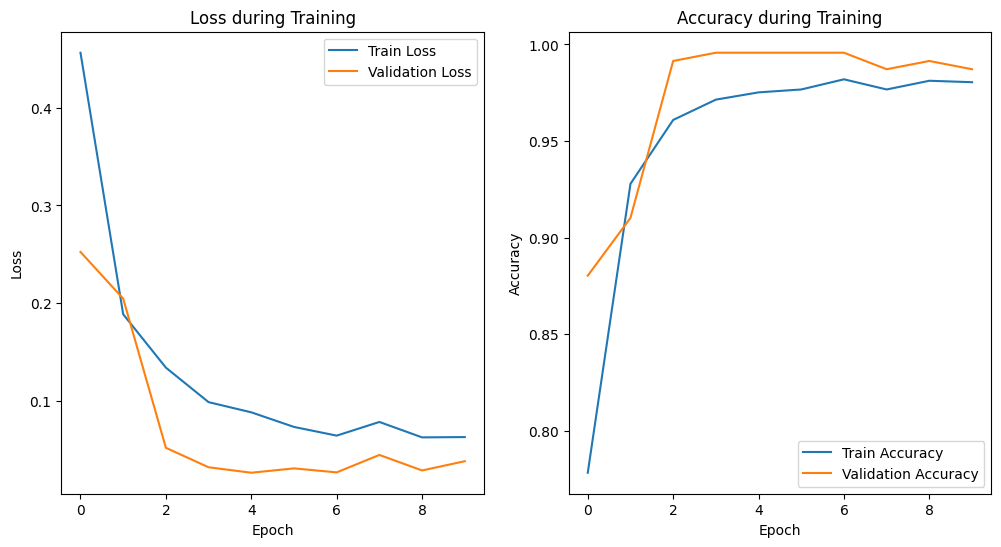

In [12]:
    # --- Plots ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [14]:
# --- Test Evaluation ---
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 198s 24s/step - accuracy: 0.9861 - loss: 0.0591
Test Loss: 0.05831145867705345
Test Accuracy: 0.9873949289321899
